In [ ]:
!pip install openpyxl
!pip install mne
import pandas as pd
import mne
import json
import matplotlib.pyplot as plt

In [84]:
file_errors_location = 'EinsatzdatenBeatmung.xlsx'
df = pd.read_excel(file_errors_location)
df.head()

,# T,Index,DateTime,Pmean,Ppeak,Pplat,etCO2,f,MVe,Vte,...,Unnamed: 101,Unnamed: 102,Unnamed: 103,Unnamed: 104,Unnamed: 105,Unnamed: 106,Unnamed: 107,Unnamed: 108,Unnamed: 109,Unnamed: 110
0,# S,Index,DateTime,peep,pInsp,pInspCcsv,vt,freq,patientType,ventilationMode,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,# A,Index,DateTime,Pinput_low,Pinput_high,peep_high,Paw_low,apnoe,flow_unrealisable,temp_high,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,I,2,13.12.2021 14:49:27,activeView=1,airmix=no,allowMaintenanceSuppress=1,allowMaintSuppress=1,apnoe=30,audioVolume=50,autoAlarmLimit=30,...,triggerInsp=5,triggerOn=0,triggerType=simple,triggerWindow=20,uptime=22714,ventilationMode=IPPV,ventPauseTime=50,version=1,vt=1300,vtKg=6
3,S,3,13.12.2021 14:49:27,5,20,60,1300,10,adult,IPPV,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,A,4,13.12.2021 14:49:27,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# file location
ventilation_file = "2021-12-13_14-49-27_MMS2_SN14638.edf"
# read via mne
ventilation_data = mne.io.read_raw_edf(ventilation_file)
ventilation_raw_data = ventilation_data.get_data()
ventilation_info = ventilation_data.info
ventilation_channels = ventilation_data.ch_names

ekg_file = "recording.edf"
ekg_data = mne.io.read_raw_edf(ekg_file)
ekg_raw_data = ekg_data.get_data()
# you can get the metadata included in the file and a list of all channels:
ekg_info = ekg_data.info
ekg_channels = ekg_data.ch_names

Extracting EDF parameters from /home/jupyter/UKE/2021-12-13_14-49-27_MMS2_SN14638.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /home/jupyter/UKE/recording.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [87]:
dictionarylist = [
    {
        "name": "PAW",
        "data": ventilation_raw_data[0],
        "resolution": 100
    },
    {
        "name": "EXTFLOWBTPS",
        "data": ventilation_raw_data[1],
        "resolution": 100
    },
    
    {
        "name": "FLOWBTPS",
        "data": ventilation_raw_data[2],
        "resolution": 100
    },
    {
        "name": "CO2_WAVE",
        "data": ventilation_raw_data[3], 
        "resolution": 40
    },
    {
        "name": "EKG_CHANNEL_2",
        "data": ekg_raw_data[0], 
        "resolution": 500
    },
    {
        "name": "EKG_CHANNEL_3",
        "data": ekg_raw_data[1], 
        "resolution": 500
    },
    {
        "name": "NULL",
        "data": ekg_raw_data[2], 
        "resolution": 500
    },
    {
        "name": "PLETH",
        "data": ekg_raw_data[3], 
        "resolution": 500
    },
    {
        "name": "HF",
        "data": ekg_raw_data[4], 
        "resolution": 1
    },
]

In [93]:
# Calculates the simple moving average
# We use this function for noise reduction in our data
def simple_moving_avg(data, n):
    averaged = []
    for i in range(len(data)):
        temp_value = 0
        for j in range(n):
            # no check for loopback when i-j < 0
            temp_value += data[i-j]
        averaged.append(1/n * temp_value)
    return averaged
     
# Example call for simple_moving_avg
# avg = simple_moving_avg(dictionarylist[5]["data"], 10)

In [68]:
sma_ekg_2 = simple_moving_avg(dictionarylist[4]["data"], 10)
sma_ekg_3 = simple_moving_avg(dictionarylist[5]["data"], 10)

In [94]:
# generate x-axis
x = [i for i in range(len(sma_ekg_2))]

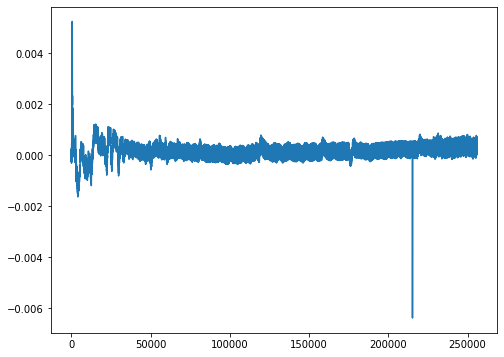

In [79]:
# Change is only really visible in a different figsize --> figsize(800, 6)
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(x, sma_ekg_2);

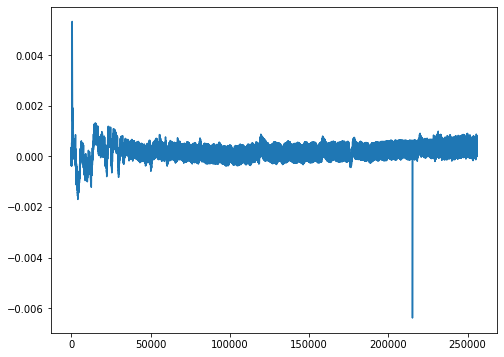

In [78]:
# No change at all | figsize(800, 6)
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(x, dictionarylist[4]["data"]);

In [65]:
with open('data.json', 'w') as f:
    json.dump({"data": dictionarylist}, f)